# Problem Statement

<p style="font-size:25px">Generating Brain Tumor MRI images for Data Augmentation using Generative Adversarial Networks</p>

# Setup

**In this project, I have used**
* Numpy and Tensorflow for Mathematical Operations
* Matplotlib and OpenCV for Image data handling and Visualization
* Keras for the Neural Networks

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
# NOISE_DIM = 100  
# BATCH_SIZE = 4 
# STEPS_PER_EPOCH = 3750
# EPOCHS = 10
# SEED = 40
# WIDTH, HEIGHT, CHANNELS = 128, 128, 1

# OPTIMIZER = Adam(0.0002, 0.5)

NOISE_DIM = 100  
BATCH_SIZE = 8   # Increase slightly from 4 to 8
STEPS_PER_EPOCH = 100  # Adjust based on dataset size
EPOCHS = 20  # Keep the same, increase to 20-30 if needed
SEED = 40  # No change
WIDTH, HEIGHT, CHANNELS = 128, 128, 1  # No change
OPTIMIZER = Adam(0.0002, 0.5)  # No change


In [3]:
MAIN_DIR = "../input/brain-mri-images-for-brain-tumor-detection/yes"

# Loading and Preprocessing the Images

In [4]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [5]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((155, 128, 128), (155,))

## Generate 20 random numbers to index images from data

In [6]:
# np.random.seed(SEED)
# idxs = np.random.randint(0, 155, 20)

In [7]:
X_train = data[:]
X_train.shape

(155, 128, 128)

## Normalize and Reshape the Data

In [8]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(155, 128, 128, 1)

## Plotting The Real Images

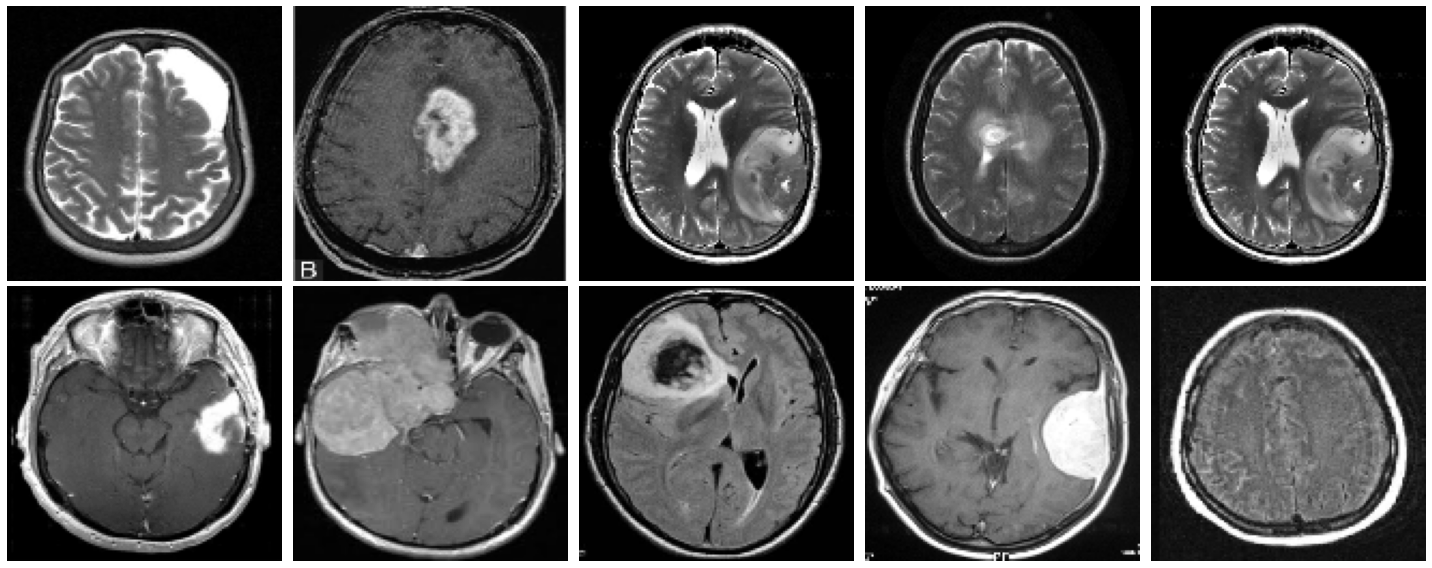

In [9]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

# The Architecture

In [10]:
def build_generator():

    """
        Generator model "generates" images using random noise. The random noise AKA Latent Vector
        is sampled from a Normal Distribution which is given as the input to the Generator. Using
        Transposed Convolution, the latent vector is transformed to produce an image
        We use 3 Conv2DTranspose layers (which help in producing an image using features; opposite
        of Convolutional Learning)

        Input: Random Noise / Latent Vector
        Output: Image
    """

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [11]:
def build_discriminator():
    
    """
        Discriminator is the model which is responsible for classifying the generated images
        as fake or real. Our end goal is to create a Generator so powerful that the Discriminator
        is unable to classify real and fake images
        A simple Convolutional Neural Network with 2 Conv2D layers connected to a Dense output layer
        Output layer activation is Sigmoid since this is a Binary Classifier

        Input: Generated / Real Image
        Output: Validity of Image (Fake or Real)

    """

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

# Putting it together

In [12]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)   

In [13]:
# def sample_images(noise, subplots, figsize=(22,8), save=False):
#     generated_images = generator.predict(noise)
#     plt.figure(figsize=figsize)
    
#     for i, image in enumerate(generated_images):
#         plt.subplot(subplots[0], subplots[1], i+1)
#         if CHANNELS == 1:
#             plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
#         else:
#             plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
#         if save == True:
#             img_name = "gen" + str(i)
#             plt.savefig(img_name)
#         plt.subplots_adjust(wspace=None, hspace=None)
#         plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    for i, image in enumerate(generated_images):
        if save:
            # Save each image as an individual file
            img_name = f"gen_{i}.png"
            plt.imsave(img_name, image.reshape((WIDTH, HEIGHT)), cmap='gray')
        else:
            # Display the images in a grid
            plt.figure(figsize=figsize)
            plt.subplot(subplots[0], subplots[1], i+1)
            if CHANNELS == 1:
                plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
            else:
                plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
            plt.axis('off')
            plt.subplots_adjust(wspace=None, hspace=None)
    if not save:
        plt.tight_layout()
        plt.show()


## The Training

In [14]:
np.random.seed(SEED)
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    # noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    # sample_images(noise, (2,5))

100%|██████████| 100/100 [00:18<00:00,  5.33it/s]


EPOCH: 1 Generator Loss: 1.5303 Discriminator Loss: 0.4114


100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


EPOCH: 2 Generator Loss: 1.4696 Discriminator Loss: 0.3944


100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


EPOCH: 3 Generator Loss: 1.3271 Discriminator Loss: 0.6028


100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


EPOCH: 4 Generator Loss: 1.5680 Discriminator Loss: 0.4724


100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


EPOCH: 5 Generator Loss: 1.0771 Discriminator Loss: 0.3500


100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


EPOCH: 6 Generator Loss: 1.5153 Discriminator Loss: 0.5714


100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


EPOCH: 7 Generator Loss: 1.3544 Discriminator Loss: 0.4422


100%|██████████| 100/100 [00:10<00:00,  9.27it/s]


EPOCH: 8 Generator Loss: 1.3746 Discriminator Loss: 0.5044


100%|██████████| 100/100 [00:10<00:00,  9.21it/s]


EPOCH: 9 Generator Loss: 1.0216 Discriminator Loss: 0.5024


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


EPOCH: 10 Generator Loss: 0.8925 Discriminator Loss: 0.5317


100%|██████████| 100/100 [00:10<00:00,  9.37it/s]


EPOCH: 11 Generator Loss: 1.4735 Discriminator Loss: 0.4044


100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


EPOCH: 12 Generator Loss: 2.4677 Discriminator Loss: 0.6693


100%|██████████| 100/100 [00:10<00:00,  9.39it/s]


EPOCH: 13 Generator Loss: 1.5188 Discriminator Loss: 0.3796


100%|██████████| 100/100 [00:10<00:00,  9.29it/s]


EPOCH: 14 Generator Loss: 0.7524 Discriminator Loss: 0.4758


100%|██████████| 100/100 [00:10<00:00,  9.43it/s]


EPOCH: 15 Generator Loss: 1.3194 Discriminator Loss: 0.6221


100%|██████████| 100/100 [00:10<00:00,  9.34it/s]


EPOCH: 16 Generator Loss: 1.2079 Discriminator Loss: 0.5363


100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


EPOCH: 17 Generator Loss: 1.7360 Discriminator Loss: 0.2613


100%|██████████| 100/100 [00:10<00:00,  9.30it/s]


EPOCH: 18 Generator Loss: 2.3639 Discriminator Loss: 0.2550


100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


EPOCH: 19 Generator Loss: 1.1318 Discriminator Loss: 0.3457


100%|██████████| 100/100 [00:10<00:00,  9.22it/s]

EPOCH: 20 Generator Loss: 2.3045 Discriminator Loss: 0.2264


# Let's generate some images !

In [15]:
noise = np.random.normal(0, 1, size=(500, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

# Testing the Generated sample: Plotting the Distributions

<p style="font-size:20px">In this test, we compare the generated images with the real samples by plotting their distributions. If the distributions overlap, that indicates the generated samples are very close to the real ones
</p>

In [16]:
generated_images = generator.predict(noise)
generated_images.shape

(500, 128, 128, 1)

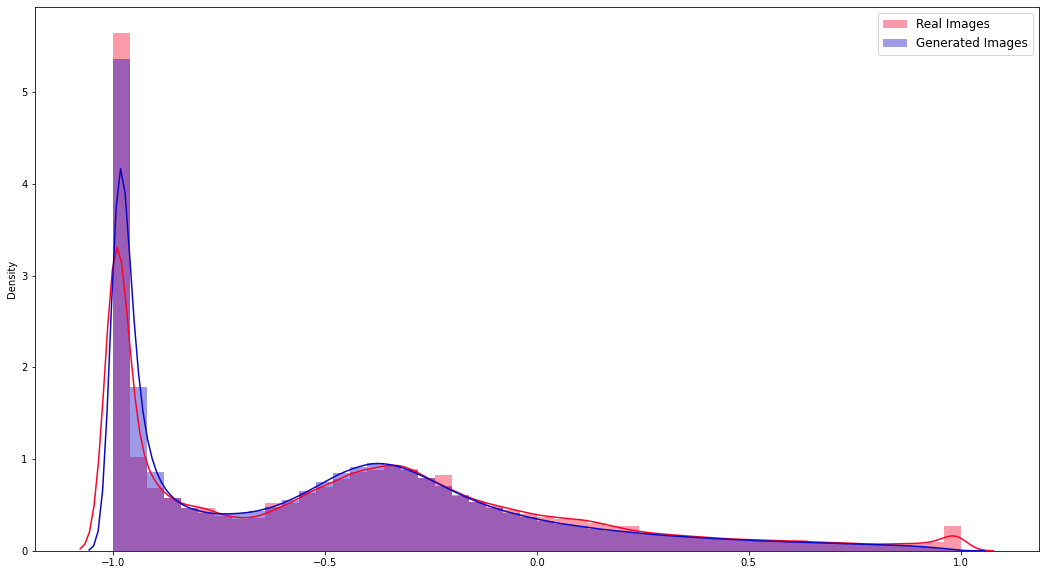

In [17]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

# Some other testing methods

<p style="font-size:20px">
<ul>
    <li style="font-size:20px">Average Log-likelihood</li>
    <li style="font-size:20px">Inception Score</li>
    <li style="font-size:20px">Wasserstien Metric</li>
</ul>
</p>

# Conclusion

<p style="font-size:20px">
    As we can see from the plot, the distribution of Generated Images is approximately the same as that of the Real Images. From this we can conclude that the generated images are a true representative of the real ones, capturing most of the variations.
</p>

# References

<p style="font-size:20px">
<ul>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1406.2661">Generative Adversarial Networks</a> (2014)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/1606.03498">Improved Techniques for Training GANs</a> (2016)</li>
    <li style="font-size:20px"><a href="https://arxiv.org/abs/2108.03235">SMOTified-GAN for class imbalanced pattern classification problems</a> (2021)</li>
</ul>
</p>